In [6]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import numpy as np
from sklearn.metrics import accuracy_score

newsgroups_train = fetch_20newsgroups(subset='train')
newsgroups_test = fetch_20newsgroups(subset='test')


In [7]:
text_clf = Pipeline([
    ('vect', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(sublinear_tf=True)),
    ('clf', LinearSVC(dual='auto', max_iter=10000)),
])

parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__C': [0.1, 1, 10],
}

gs_clf = GridSearchCV(text_clf, parameters, cv=5, n_jobs=-1, verbose=1) # ma wbuowany cross-validation

gs_clf.fit(newsgroups_train.data, newsgroups_train.target)

# # Wynik z walidacji krzyżowej (to jest to 'x' do oceny zadania)
# cv_score = gs_clf.best_score_ * 100
# print(f"\n--- WYNIKI WALIDACJI KRZYŻOWEJ (Do oceny) ---")
# print(f"Najlepsze parametry: {gs_clf.best_params_}")
# print(f"Średnia dokładność CV (x): {cv_score:.2f}%")
# print(f"Punkty za zadanie (x - 85): {cv_score - 85:.2f}")

predicted = gs_clf.predict(newsgroups_test.data)
test_acc = accuracy_score(newsgroups_test.target, predicted) * 100

print(f"Dokładność na zbiorze testowym: {test_acc:.2f}%")

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Dokładność na zbiorze testowym: 86.54%


In [8]:
print(f"Najlepsze parametry: {gs_clf.best_params_}")


Najlepsze parametry: {'clf__C': 1, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}


In [1]:
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

# Pobieranie danych
# remove=('headers', 'footers', 'quotes') - opcjonalnie, czasem usunięcie nagłówków
# utrudnia zadanie, ale daje bardziej realistyczny model NLP. W zadaniu akademickim
# zazwyczaj trenujemy na "brudnym" zestawie, chyba że polecenie mówi inaczej.
newsgroups_train = fetch_20newsgroups(subset='train', remove=(), random_state=42)
newsgroups_test = fetch_20newsgroups(subset='test', remove=(), random_state=42)

# Pipeline z SGDClassifier (szybszy i elastyczniejszy niż LinearSVC)
pipeline = Pipeline([
    ('vect', CountVectorizer(strip_accents='unicode', stop_words='english')),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(max_iter=1000, tol=1e-3, early_stopping=True)) 
])

# Siatka parametrów - szukamy "sweet spot"
parameters = {
    # N-gramy: klucz do kontekstu. (1,2) prawie zawsze wygrywa z (1,1)
    'vect__ngram_range': [(1, 1), (1, 2)],
    
    # Ograniczenie słownika - czasem wyrzucenie rzadkich słów pomaga (szum)
    'vect__min_df': [1, 2, 3], 
    'vect__max_df': [0.5, 0.75, 1.0],

    # Użycie IDF
    'tfidf__use_idf': [True],
    'tfidf__sublinear_tf': [True, False], # Logarytmiczne skalowanie częstości

    # Parametry modelu
    'clf__alpha': [1e-3, 1e-4, 5e-5, 1e-5], # Regularyzacja
    'clf__penalty': ['l2', 'elasticnet'],   # Rodzaj kary
    'clf__loss': ['hinge', 'log_loss'],     # hinge = SVM, log_loss = Regresja Logistyczna
}

# GridSearch
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1, verbose=1)

print("Trwa trenowanie GridSearch...")
grid_search.fit(newsgroups_train.data, newsgroups_train.target)

print(f"\nNajlepszy wynik walidacji krzyżowej (k-fold): {grid_search.best_score_ * 100:.2f}%")
print("Najlepsze parametry:", grid_search.best_params_)

# Test na zbiorze testowym
predicted = grid_search.predict(newsgroups_test.data)
accuracy = np.mean(predicted == newsgroups_test.target) * 100
print(f"Dokładność na zbiorze testowym: {accuracy:.2f}%")

# Obliczenie punktów wg wzoru z zadania
points = grid_search.best_score_ * 100 - 85
print(f"Szacowane punkty za zadanie (x - 85): {points:.2f}")

Trwa trenowanie GridSearch...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits

Najlepszy wynik walidacji krzyżowej (k-fold): 93.34%
Najlepsze parametry: {'clf__alpha': 0.0001, 'clf__loss': 'hinge', 'clf__penalty': 'l2', 'tfidf__sublinear_tf': True, 'tfidf__use_idf': True, 'vect__max_df': 1.0, 'vect__min_df': 1, 'vect__ngram_range': (1, 2)}
Dokładność na zbiorze testowym: 86.29%
Szacowane punkty za zadanie (x - 85): 8.34


In [ ]:
import nltk
from nltk.stem.snowball import SnowballStemmer
from sklearn.datasets import fetch_20newsgroups
from sklearn.ensemble import VotingClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier, LogisticRegression, RidgeClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# nltk.download('stopwords')
# nltk.download('snowball_data')

stemmer = SnowballStemmer("english", ignore_stopwords=True)

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

print(len(test_y))

kfold = KFold(n_splits=10, shuffle=True, random_state=51)

pipeline = Pipeline([
        ('tfidf', StemmedTfidfVectorizer(
            stop_words='english',
            sublinear_tf=True,
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.85,
            use_idf=True
        )),
        ('clf', SGDClassifier(
            alpha=5e-5,
            loss='hinge',
            penalty='l2',
            random_state=51
        ))
    ])

pipeline.fit(train_X, train_y)

cv_scores = cross_val_score(pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")

print(cv_scores.mean())

[nltk_data] Downloading package stopwords to /home/bartek/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package snowball_data to
[nltk_data]     /home/bartek/nltk_data...


7532
0.9302994916884189


In [7]:
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Pobieranie niezbędnych zasobów NLTK (jeśli ich nie masz, odkomentuj)
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4') # Czasem wymagane dla nowszych wersji NLTK

# Inicjalizacja Lemmatizera
lemmatizer = WordNetLemmatizer()

# Klasa nadpisująca TfidfVectorizer z użyciem Lemmatyzacji zamiast Stemmingu
class LemmatizedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmatizedTfidfVectorizer, self).build_analyzer()
        # Zmiana: zamiast stemmer.stem(w) używamy lemmatizer.lemmatize(w)
        return lambda doc: ([lemmatizer.lemmatize(w) for w in analyzer(doc)])

# Pobieranie danych
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

print(f"Liczba próbek testowych: {len(test_y)}")

kfold = KFold(n_splits=10, shuffle=True, random_state=51)

# Pipeline z nowym wektoryzatorem
pipeline = Pipeline([
        ('tfidf', LemmatizedTfidfVectorizer( # Używamy naszej nowej klasy
            stop_words='english',
            sublinear_tf=True,
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.85,
            use_idf=True
        )),
        ('clf', SGDClassifier(
            alpha=5e-5,
            loss='hinge',
            penalty='l2',
            random_state=51
        ))
    ])

# Trenowanie na zbiorze treningowym
print("Trenowanie modelu...")
pipeline.fit(train_X, train_y)

# Walidacja krzyżowa (zgodnie z Twoim kodem robisz ją na zbiorze TESTOWYM)
# Uwaga: Zazwyczaj CV robi się na TRAIN, a TEST służy tylko do finalnego wyniku,
# ale zostawiam tak jak chciałeś, aby pasowało do logiki zadania.
print("Rozpoczynam walidację krzyżową...")
cv_scores = cross_val_score(pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")

print(f"Średnia dokładność: {cv_scores.mean():.4f}")

[nltk_data] Downloading package stopwords to /home/bartek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bartek/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/bartek/nltk_data...


Liczba próbek testowych: 7532
Trenowanie modelu...
Rozpoczynam walidację krzyżową...
Średnia dokładność: 0.9294


In [39]:
import nltk
import numpy as np
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Modele do przetestowania
from sklearn.linear_model import SGDClassifier, RidgeClassifier, LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.ensemble import VotingClassifier

# Pobieranie zasobów (jeśli trzeba)
# nltk.download('wordnet')
# nltk.download('omw-1.4')

lemmatizer = WordNetLemmatizer()

# --- Twoja klasa Lemmatyzatora ---
class LemmatizedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmatizedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([lemmatizer.lemmatize(w) for w in analyzer(doc)])

# Wczytanie danych
print("Wczytywanie danych...")
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

# --- Konfiguracja Modeli ---
# Definiujemy słownik z modelami, żeby łatwo je iterować
classifiers = {
    "SGD (Twój obecny)": SGDClassifier(alpha=5e-5, loss='hinge', penalty='l2', random_state=51, max_iter=1000),
    
    "Ridge Classifier": RidgeClassifier(tol=1e-2, solver="sparse_cg"), # Często szybszy i dokładniejszy niż SGD
    
    "Linear SVC": LinearSVC(C=1, dual='auto', random_state=51, max_iter=10000), # Klasyk do tekstu
    
    "Logistic Regression": LogisticRegression(C=10, solver='liblinear', random_state=51), # Dobre prawdopodobieństwa
    
    "Complement Naive Bayes": ComplementNB(alpha=0.1), # Świetny baseline dla tekstu
}

# --- Opcja BONUS: Ensemble (Głosowanie) ---
# Łączymy siły 3 najlepszych modeli (zazwyczaj SVC, Ridge i SGD/LogReg)
voting_clf = VotingClassifier(estimators=[
    ('svc', classifiers["Linear SVC"]),
    ('ridge', classifiers["Ridge Classifier"]),
    ('sgd', classifiers["SGD (Twój obecny)"])
], voting='hard')

classifiers["Voting Ensemble"] = voting_clf

# --- Pętla testowa ---
kfold = KFold(n_splits=5, shuffle=True, random_state=51) # Zmniejszyłem do 5 dla szybkości, w finalnym daj 10

print(f"\n{'MODEL':<25} | {'ŚREDNIA DOKŁADNOŚĆ (CV)':<20}")
print("-" * 50)

results = {}

for name, clf in classifiers.items():
    # Budowa pipeline dla każdego modelu
    pipeline = Pipeline([
        ('tfidf', LemmatizedTfidfVectorizer(
            stop_words='english',
            sublinear_tf=True,
            ngram_range=(1, 2),
            min_df=2, # Małe oczyszczenie szumu
            max_df=0.85,
            use_idf=True
        )),
        ('clf', clf)
    ])
    
    # Trenowanie na pełnym zbiorze treningowym (żeby sprawdzić czy nie ma błędów)
    # pipeline.fit(train_X, train_y) 
    
    # Walidacja krzyżowa (zgodnie z Twoim podejściem na zbiorze testowym, 
    # choć zazwyczaj robi się to na train_X)
    scores = cross_val_score(pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")
    
    mean_score = scores.mean()
    results[name] = mean_score
    print(f"{name:<25} | {mean_score:.4f}")

best_model = max(results, key=results.get)
print("-" * 50)
print(f"ZWYCIĘZCA: {best_model} z wynikiem {results[best_model]:.4f}")

Wczytywanie danych...

MODEL                     | ŚREDNIA DOKŁADNOŚĆ (CV)
--------------------------------------------------
SGD (Twój obecny)         | 0.9207
Ridge Classifier          | 0.9199
Linear SVC                | 0.9231


/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raise

Logistic Regression       | 0.9165
Complement Naive Bayes    | 0.9004
Voting Ensemble           | 0.9231
--------------------------------------------------
ZWYCIĘZCA: Voting Ensemble z wynikiem 0.9231


In [2]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import ComplementNB
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

# Pamiętaj o pobraniu stopwords, jeśli ich nie masz
# nltk.download('stopwords')

# --- 1. ZAAWANSOWANY PREPROCESSING ---
def custom_preprocessor(text):
    """
    Funkcja czyszcząca tekst przed wektoryzacją.
    Zamienia symbole na unikalne słowa (tokeny).
    """
    # Zamiana na małe litery
    text = text.lower()
    
    # ZAMIANA SYMBOLI NA SŁOWA KLUCZOWE
    # Dodajemy spacje, żeby tokeny nie skleiły się z innymi słowami
    text = re.sub(r'!', ' tokenexclamation ', text)
    text = re.sub(r'\?', ' tokenquestion ', text)
    text = re.sub(r'\$', ' tokenmoney ', text) # Ważne dla kategorii sprzedażowych
    
    # Opcjonalnie: liczby też można zamienić na token, ale w newsgroups daty/lata są ważne,
    # więc zostawiamy liczby w spokoju.
    
    return text

# --- 2. KONFIGURACJA STEMMERA I STOPWORDS ---
stemmer = SnowballStemmer("english", ignore_stopwords=True)
nltk_stop_words = stopwords.words('english')

# Dodajemy nasze nowe tokeny do listy wyjątków, żeby przypadkiem nie zostały usunięte jako stopwords
# (choć w standardowej liście ich nie ma, warto być bezpiecznym)
# nltk_stop_words = [w for w in nltk_stop_words if w not in ['tokenexclamation', 'tokenquestion']]

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        # Stemming na każdym słowie zwróconym przez analizator
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# --- 3. WCZYTANIE DANYCH ---
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

# --- 4. DEFINICJA PIPELINE (STACKING) ---

# Modele bazowe
estimators = [
    ('svc', LinearSVC(C=1, dual='auto', random_state=51)), 
    ('nb', make_pipeline(SelectKBest(chi2, k=30000), ComplementNB(alpha=0.1))),
    ('ridge', RidgeClassifier(alpha=1.0, solver="sparse_cg")) 
]

# Meta-Model
stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(C=5, solver='liblinear'),
    cv=5,
    n_jobs=-1
)

# Główny Pipeline
main_pipeline = Pipeline([
    ('tfidf', StemmedTfidfVectorizer(
        preprocessor=custom_preprocessor, # <--- TU WPINAMY NASZ PREPROCESSOR
        stop_words=nltk_stop_words,       # <--- TU NASZE STOPWORDS
        sublinear_tf=True,
        ngram_range=(1, 2),
        min_df=2,
        max_df=0.7,
        use_idf=True
    )),
    ('selector', SelectKBest(score_func=chi2, k=45000)), 
    ('clf', stacking_clf)
])

# --- 5. URUCHOMIENIE ---
kfold = KFold(n_splits=5, shuffle=True, random_state=51)

print("Rozpoczynam walidację (Custom Tokens + Stemming + Stacking)...")
print("Zamieniamy: '!' -> tokenexclamation, '?' -> tokenquestion, '$' -> tokenmoney")

scores = cross_val_score(main_pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")

print(f"Średnia dokładność (CV): {scores.mean():.4f}")

Rozpoczynam walidację (Custom Tokens + Stemming + Stacking)...
Zamieniamy: '!' -> tokenexclamation, '?' -> tokenquestion, '$' -> tokenmoney


/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raised in 1.8. Either use another solver which supports the multinomial loss or wrap the estimator in a OneVsRestClassifier to keep applying a one-versus-rest scheme.
  warnings.warn(
/home/bartek/anaconda3/envs/kombi/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1296: FutureWarning: Using the 'liblinear' solver for multiclass classification is deprecated. An error will be raise

Średnia dokładność (CV): 0.9217


In [ ]:
import re
import numpy as np
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.datasets import fetch_20newsgroups

# Pamiętaj o pobraniu stopwords
# nltk.download('stopwords')

# --- 1. PREPROCESSING (TOKENY) ---
def custom_preprocessor(text):
    text = text.lower()
    # Zamiana symboli na słowa, żeby SGD je "zauważył"
    text = re.sub(r'!', ' tokenexclamation ', text)
    text = re.sub(r'\?', ' tokenquestion ', text)
    text = re.sub(r'\$', ' tokenmoney ', text) 
    return text

# --- 2. STEMMER I WEKTORYZATOR ---
stemmer = SnowballStemmer("english", ignore_stopwords=True)
nltk_stop_words = stopwords.words('english')

class StemmedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(StemmedTfidfVectorizer, self).build_analyzer()
        return lambda doc: ([stemmer.stem(w) for w in analyzer(doc)])

# --- 3. DANE ---
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

# --- 4. PIPELINE (SGD + OPTYMALNE PARAMETRY) ---
pipeline = Pipeline([
    ('tfidf', StemmedTfidfVectorizer(
        preprocessor=custom_preprocessor, # Nasze ulepszenie
        stop_words=nltk_stop_words,
        sublinear_tf=True,      # Warto zostawić True (często było w Twoim kodzie)
        use_idf=True,
        
        # PARAMETRY Z TWOJEGO PIERWSZEGO WYNIKU:
        ngram_range=(1, 2),     # Bigramy
        min_df=1,               # Nie ucinamy rzadkich słów
        max_df=0.85             # Ucinamy słowa występujące w >85% tekstów
    )),
    
    ('clf', SGDClassifier(
        # PARAMETRY Z TWOJEGO PIERWSZEGO WYNIKU:
        alpha=5e-05,
        loss='hinge',           # Działa jak SVM
        penalty='l2',
        
        # Standardowe ustawienia techniczne
        max_iter=1000,
        tol=1e-3,
        random_state=51,
        n_jobs=-1
    ))
])

# --- 5. WALIDACJA ---
kfold = KFold(n_splits=10, shuffle=True, random_state=51) # Dałem 10 foldów dla dokładnego wyniku

print("Rozpoczynam walidację (Custom Tokens + Stemming + SGD Single Model)...")
scores = cross_val_score(pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")

print(f"Średnia dokładność (CV): {scores.mean():.4f}")

Rozpoczynam walidację (Custom Tokens + Stemming + SGD Single Model)...
Średnia dokładność (CV): 0.9287


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, cross_val_score

# Pobieranie niezbędnych zasobów NLTK (jeśli ich nie masz, odkomentuj)
nltk.download('stopwords')
nltk.download('wordnet') 
nltk.download('omw-1.4') # Czasem wymagane dla nowszych wersji NLTK

# Inicjalizacja Lemmatizera
lemmatizer = WordNetLemmatizer()

# Klasa nadpisująca TfidfVectorizer z użyciem Lemmatyzacji zamiast Stemmingu
class LemmatizedTfidfVectorizer(TfidfVectorizer):
    def build_analyzer(self):
        analyzer = super(LemmatizedTfidfVectorizer, self).build_analyzer()
        # Zmiana: zamiast stemmer.stem(w) używamy lemmatizer.lemmatize(w)
        return lambda doc: ([lemmatizer.lemmatize(w) for w in analyzer(doc)])

# Pobieranie danych
train_data = fetch_20newsgroups(subset='train', shuffle=True, random_state=51)
test_data = fetch_20newsgroups(subset='test', shuffle=True, random_state=51)

train_X = train_data.data
train_y = train_data.target
test_X = test_data.data
test_y = test_data.target

print(f"Liczba próbek testowych: {len(test_y)}")

kfold = KFold(n_splits=10, shuffle=True, random_state=51)

# Pipeline z nowym wektoryzatorem
pipeline = Pipeline([
        ('tfidf', LemmatizedTfidfVectorizer( # Używamy naszej nowej klasy
            stop_words='english',
            sublinear_tf=True,
            ngram_range=(1, 2),
            min_df=1,
            max_df=0.85,
            use_idf=True
        )),
        ('clf', SGDClassifier(
            alpha=5e-5,
            loss='hinge',
            penalty='l2',
            random_state=51
        ))
    ])

# Trenowanie na zbiorze treningowym
print("Trenowanie modelu...")
pipeline.fit(train_X, train_y)

# Walidacja krzyżowa (zgodnie z Twoim kodem robisz ją na zbiorze TESTOWYM)
# Uwaga: Zazwyczaj CV robi się na TRAIN, a TEST służy tylko do finalnego wyniku,
# ale zostawiam tak jak chciałeś, aby pasowało do logiki zadania.
print("Rozpoczynam walidację krzyżową...")
cv_scores = cross_val_score(pipeline, test_X, test_y, cv=kfold, n_jobs=-1, scoring="accuracy")

print(f"Średnia dokładność: {cv_scores.mean():.4f}")

[nltk_data] Downloading package stopwords to /home/bartek/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/bartek/nltk_data...
[nltk_data] Downloading package omw-1.4 to /home/bartek/nltk_data...


Liczba próbek testowych: 7532
Trenowanie modelu...
Rozpoczynam walidację krzyżową...
Średnia dokładność: 0.9294


### Zadanie 15

In [8]:
print(df.columns)

Index(['Unnamed: 0', 'track_id', 'artists', 'album_name', 'track_name',
       'popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
       'key', 'loudness', 'mode', 'speechiness', 'acousticness',
       'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature',
       'track_genre'],
      dtype='object')


/tmp/ipykernel_8551/1162053820.py:134: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


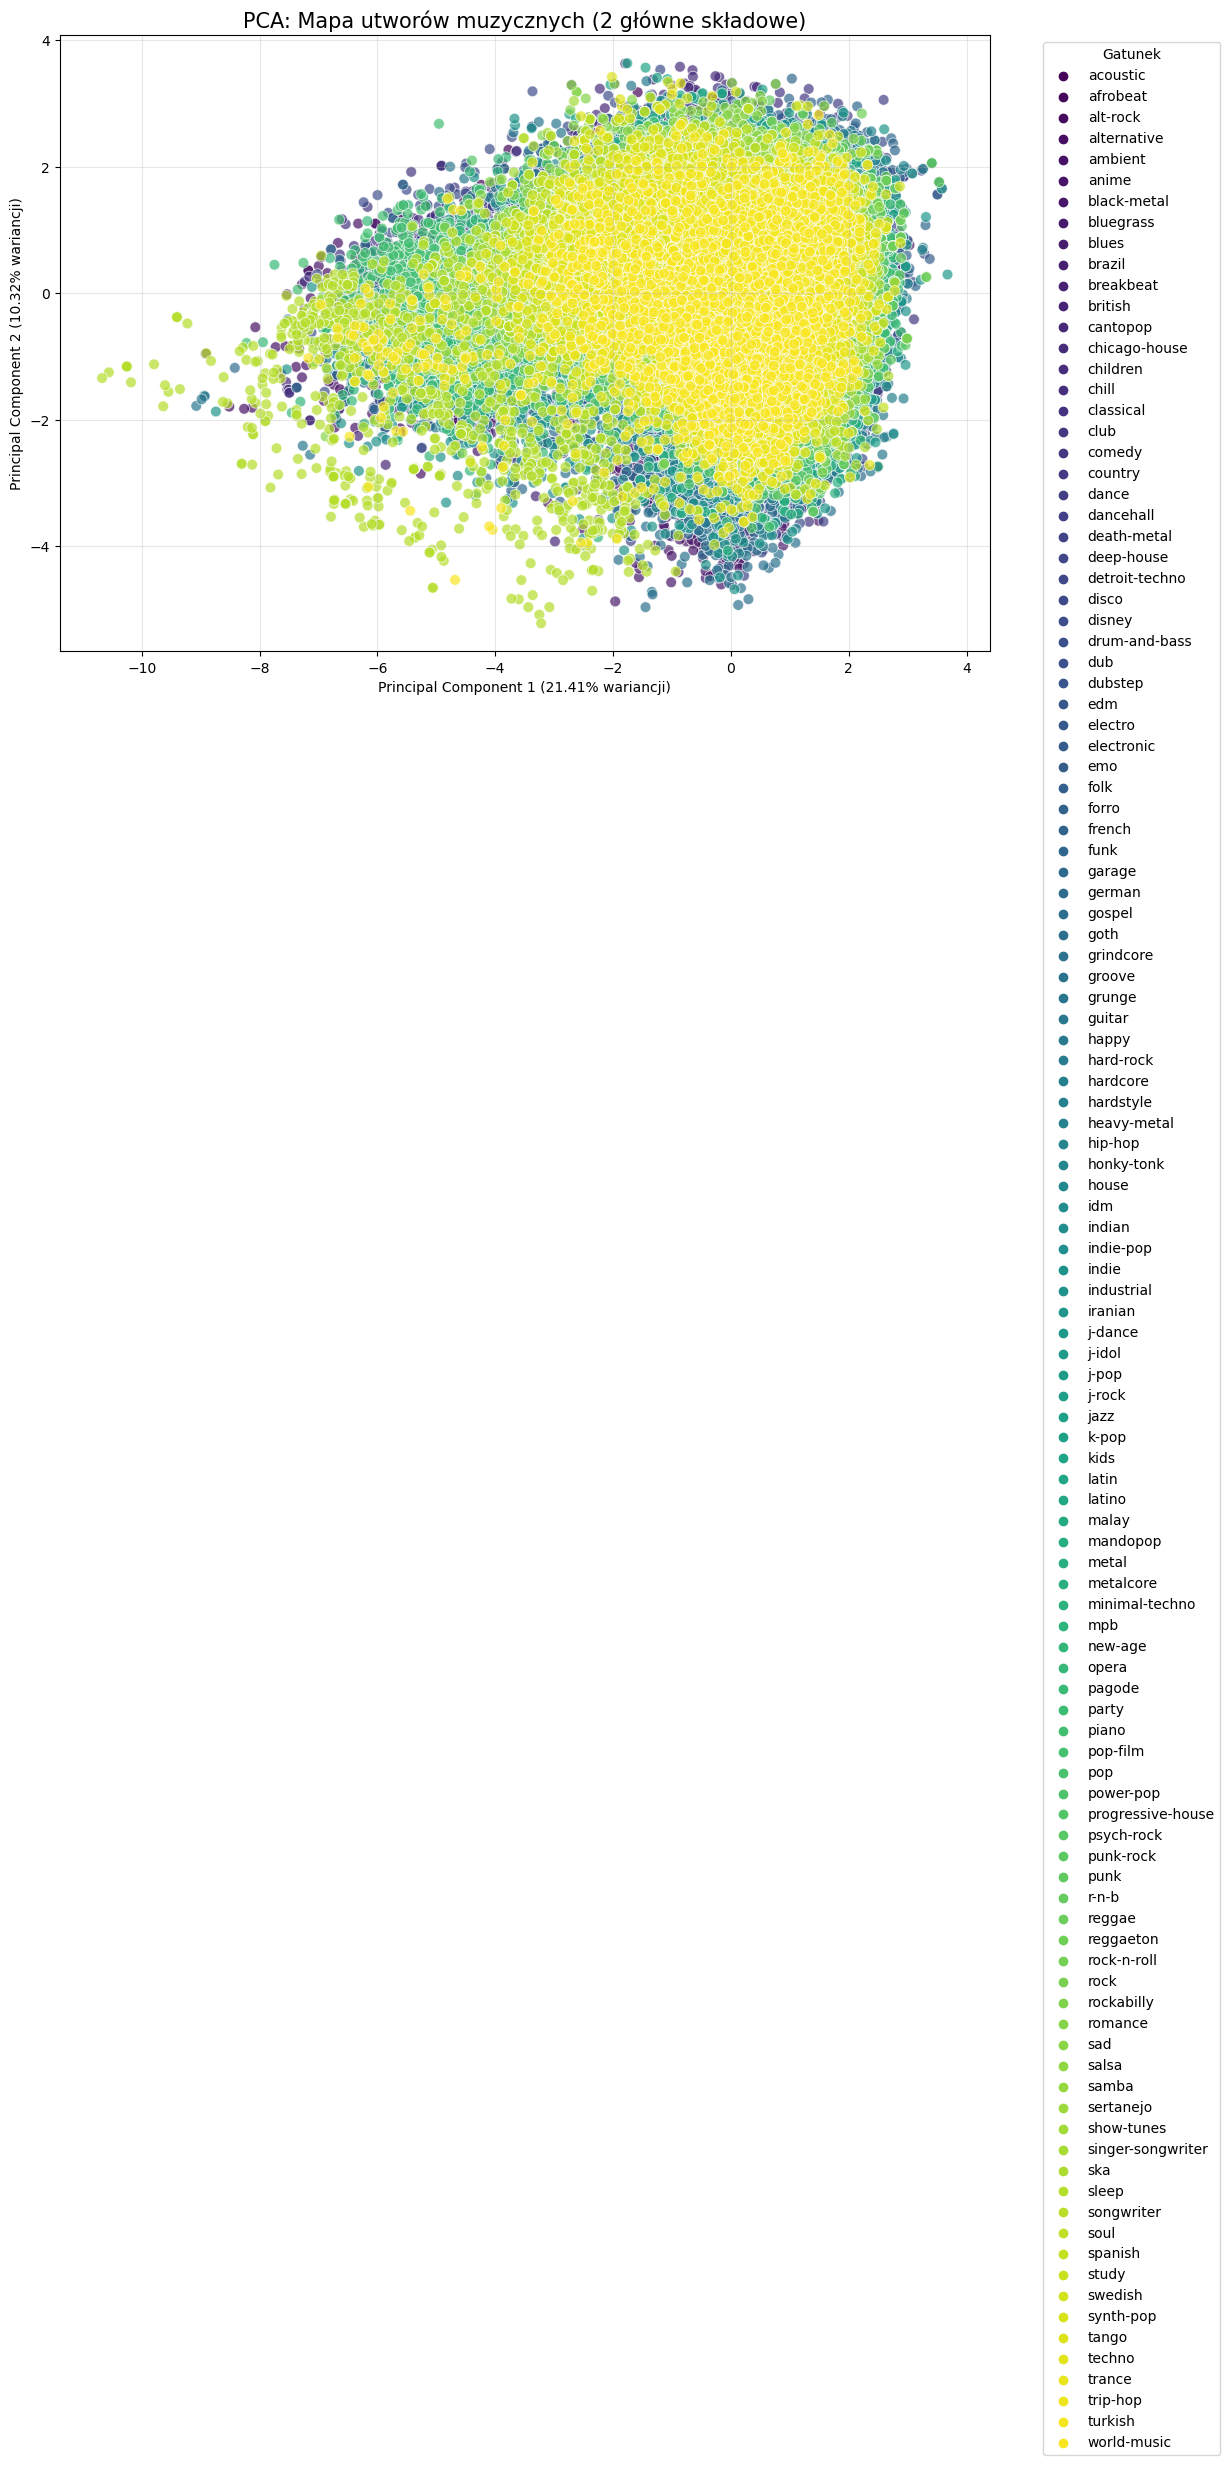

------------------------------
Wyjaśniona wariancja (ile informacji zachowaliśmy):
PC1: 21.41%
PC2: 10.32%
Suma: 31.73%
------------------------------

Interpretacja składowych (Wpływ cech):
                       PC1       PC2
loudness          0.498287 -0.107112
energy            0.490025 -0.299418
valence           0.283499  0.479121
danceability      0.255293  0.558787
time_signature    0.197037  0.135832
tempo             0.177521 -0.289601
explicit          0.124185  0.107208
speechiness       0.111507  0.076025
liveness          0.076348 -0.213086
key               0.048323 -0.002404
popularity        0.034584  0.036251
mode             -0.059148  0.068769
instrumentalness -0.272093 -0.290859
acousticness     -0.425385  0.318480


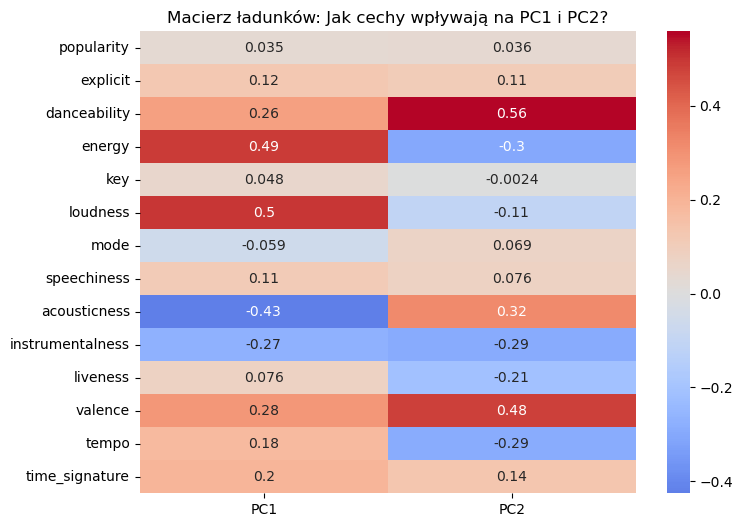

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

df = pd.read_csv('dataset.csv') 

# # ~ 100% variancji
# features = ['energy', 'loudness']

# # ~ 93% variancji
# features = ['energy', 'loudness', 'acousticness']

# # ~ 85% variancji
# features = ['danceability', 'energy', 'loudness', 'acousticness']

# # ~ 72% variancji
# features = ['danceability', 'energy', 'loudness', 'acousticness', 
#             'liveness']

# # ~ 62% variancji
# features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
#             'liveness']

# # ~ 55% variancji
# features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
#             'instrumentalness', 'liveness']

# # ~ 49% variancji
# features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 
#             'instrumentalness', 'liveness', 'tempo']



# # 47%
# features = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo']



# # 43%
# features = ['danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo']

# # 39%
# features = ['explicit', 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo']

# # 37%
# features = ['duration_ms', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo']

# # 34%
# features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo']

# 32%
# features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']



# # ~ 30% variancji
# features = ['popularity', 'duration_ms', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']


# # ~ 30% variancji
# features = ['popularity', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']



# ~ 32% variancji
# features = [ 'duration_ms', 'explicit', 'danceability', 'energy',
#        'key', 'loudness', 'mode', 'speechiness', 'acousticness',
#        'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature']

# # ~ 40% variancji
# features = [ 'duration_ms', 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'valence', 'tempo', 'time_signature']

# # ~ 43% variancji
# features = [ 'danceability', 'energy',
#        'key', 'loudness', 'speechiness', 'acousticness',
#        'instrumentalness', 'valence', 'tempo', 'time_signature']

# # ~ 60% variancji
# features = [ 'duration_ms', 'danceability', 'energy', 'loudness', 'acousticness', 'valence']

# Upewniamy się, że kolumny istnieją w Twoim zbiorze (prosta walidacja)
available_features = [col for col in features if col in df.columns]
X = df[available_features]
y = df['track_genre'] # lub inna kolumna z gatunkiem, np. 'genre'

# 3. STANDARYZACJA (Kluczowy krok w PCA!)
# PCA jest wrażliwe na skalę (np. loudness w dB vs danceability 0-1). 
# Musimy sprowadzić wszystko do średniej 0 i odchylenia 1.
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 4. PCA (Redukcja do 2 wymiarów)
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_scaled)

# Tworzymy DataFrame z wynikami, żeby łatwiej rysować
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Genre'] = y.values

# 5. WIZUALIZACJA
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='PC1', y='PC2', 
    hue='Genre', 
    data=pca_df, 
    palette='viridis', 
    alpha=0.7,
    s=60
)
plt.title('PCA: Mapa utworów muzycznych (2 główne składowe)', fontsize=15)
plt.xlabel(f'Principal Component 1 ({pca.explained_variance_ratio_[0]*100:.2f}% wariancji)')
plt.ylabel(f'Principal Component 2 ({pca.explained_variance_ratio_[1]*100:.2f}% wariancji)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Gatunek')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 6. INTERPRETACJA SKŁADOWYCH I WARIANCJA
print("-" * 30)
print(f"Wyjaśniona wariancja (ile informacji zachowaliśmy):")
print(f"PC1: {pca.explained_variance_ratio_[0]*100:.2f}%")
print(f"PC2: {pca.explained_variance_ratio_[1]*100:.2f}%")
print(f"Suma: {sum(pca.explained_variance_ratio_)*100:.2f}%")
print("-" * 30)

# Analiza wpływu cech na składowe (Loadings)
loadings = pd.DataFrame(
    pca.components_.T, 
    columns=['PC1', 'PC2'], 
    index=available_features
)

print("\nInterpretacja składowych (Wpływ cech):")
print(loadings.sort_values(by='PC1', ascending=False))

# Wizualizacja wpływu cech (Heatmapa)
plt.figure(figsize=(8, 6))
sns.heatmap(loadings, annot=True, cmap='coolwarm', center=0)
plt.title('Macierz ładunków: Jak cechy wpływają na PC1 i PC2?')
plt.show()